# RAG w/ Langgraph
랭그래프에 RAG 추가하기

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
# RAG 준비

# 1. Loader
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),  # 여러개 가져오려면 튜플 안에 추가하면 됨
    # 웹페이지에서 필요한 정보를 선택하기
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content'])
    },
    # header_template={},
)
docs = loader.load()

# 웹페이지를 그대로 긁어오면, 필요없는 부분(사이트 제목, 밑에 광고들, 등등)이 뒤섞여서 나온다. -> 필요한 부분을 선택적으로 가져와야 함 -> bs_kwargs
# from pprint import pprint
# pprint(docs[0].page_content)

# 2. Splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=500
)
splitted_docs = splitter.split_documents(docs)
# print(len(splitted_docs))

# 3. Enbedding Model
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-small')  # small <-> large

# 4. Vectorstore (일단은 FAISS, 나중엔 클라우드(Pinecone)에 저장할 것)
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

In [ ]:
# 프롬프트
from langchain import hub

prompt = hub.pull('rlm/rag-prompt')
for msg in prompt.messages:
    msg.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


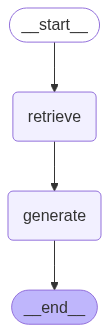

In [ ]:
# 랭그래프

# 1. State
from typing_extensions import TypedDict, List
from langchain_core.documents import Document

class State(TypedDict):
    # 프롬프트에 뚫린 구멍은 반드시 채워줘야함
    question: str  # 사용자의 질문
    context: List[Document]  # LLM에게 전달할 RAG 데이터의 문서조각. List[Document]는 context에 Document 객체가 리스트로 모여있을 것이라는 의미
    answer: str  # LLM의 답안

# 2. Node
# 2-1. 검색노드
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state['question'], k=4)  # [Document 타입 객체 x 4]
    
    # 내용에 해당하는 page_content만 모아서 토큰 절약
    context_str = ''
    for doc in retrieved_docs:
        context_str += doc.page_content + '\n-----------------------------------------------\n'
    
    return {'context': context_str}  # 언급하지 않은 state 항목들(question, answer)은 내부적으로 알아서 그대로 들어가짐

# 2-2. 답변생성노드
from langchain_openai import ChatOpenAI

def generate(state: State):
    question_with_context = prompt.invoke({'question': state['question'], 'context': state['context']})
    llm = ChatOpenAI(model='gpt-4.1', temperature=0)
    res = llm.invoke(question_with_context)    
    return {'answer': res.content}

# 3. Graph
from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)

builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

# 4. 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
final_state = graph.invoke({'question': '에이전트 시스템에 대해 알려줘'}) 

print(final_state['answer'])

에이전트 시스템은 주어진 목표를 달성하기 위해 자율적으로 작업을 수행하는 소프트웨어 구조입니다. LLM(대형 언어 모델) 기반 에이전트 시스템은 인터넷 검색, 장기 기억 관리, 파일 출력, 외부 API 호출 등 다양한 도구를 활용해 복잡한 문제를 해결할 수 있습니다. 또한, 자신의 행동을 지속적으로 평가하고 개선하며, 효율적으로 작업을 수행하도록 설계되어 있습니다.
